In [19]:
import numpy as np
import ufl
from mpi4py import MPI
from petsc4py import PETSc

import dolfinx
from dolfinx import fem, mesh, io, plot
from dolfinx.fem.petsc import LinearProblem
import dolfinx.geometry

# Visualization imports
import matplotlib.pyplot as plt
import pyvista as pv
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

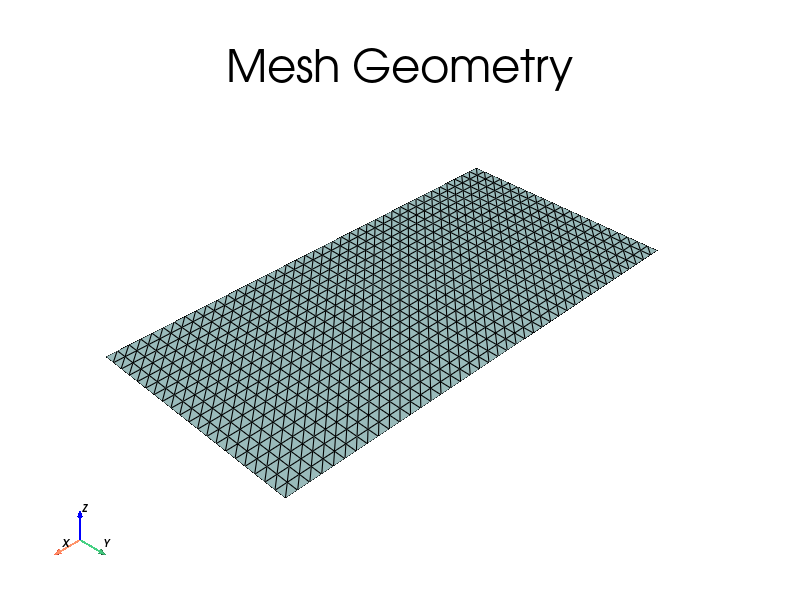

In [ ]:

def create_electrode_geometry():
    # Create rectangular domain
    domain = mesh.create_rectangle(
        MPI.COMM_WORLD,
        [np.array([0.0, 0.0]), np.array([2.0, 1.0])],
        [40, 20],
        mesh.CellType.triangle
    )
    return domain


def visualize_mesh(domain, title="Mesh Geometry"):
    """Visualize the mesh using pyvista"""
    try:
        # Create pyvista mesh
        topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
        grid = pv.UnstructuredGrid(topology, cell_types, geometry)
        
        # Create plotter
        plotter = pv.Plotter(window_size=(800, 600))
        plotter.add_mesh(grid, show_edges=True, color='lightblue', edge_color='black')
        plotter.add_title(title)
        plotter.show_axes()
        plotter.show()
        
    except Exception as e:
        print(f"PyVista visualization failed: {e}")
        print("Falling back to matplotlib visualization...")
        
        # Fallback to matplotlib
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set_aspect('equal')
        ax.set_title(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
        # Get mesh coordinates
        x = domain.geometry.x
        cells = domain.topology.connectivity(domain.topology.dim, 0).array.reshape(-1, 3)
        
        # Plot triangles
        for cell in cells:
            triangle = x[cell]
            triangle = np.vstack([triangle, triangle[0]])  # Close the triangle
            ax.plot(triangle[:, 0], triangle[:, 1], 'b-', alpha=0.3, linewidth=0.5)
        
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

domain = create_electrode_geometry()
visualize_mesh(domain)

In [23]:


def mark_electrode_boundaries(domain):
    tdim = domain.topology.dim
    fdim = tdim - 1
    
    # Initialize facet markers
    domain.topology.create_connectivity(fdim, tdim)
    boundary_facets = mesh.exterior_facet_indices(domain.topology)
    
    # Create MeshTags for boundary marking
    facet_markers = np.zeros(len(boundary_facets), dtype=np.int32)
    
    # Get boundary facet coordinates
    boundary_dofs = fem.locate_dofs_topological(
        fem.functionspace(domain, ("Lagrange", 1)), 
        fdim, 
        boundary_facets
    )
    
    # Mark different electrode regions
    # Left electrode (x = 0, y in [0.2, 0.8])
    # Right electrode (x = 2, y in [0.2, 0.8])
    # Ground boundaries (top and bottom)
    
    def on_left_electrode(x):
        return np.logical_and(
            np.isclose(x[0], 0.0, atol=1e-10),
            np.logical_and(x[1] >= 0.2, x[1] <= 0.8)
        )
    
    def on_right_electrode(x):
        return np.logical_and(
            np.isclose(x[0], 2.0, atol=1e-10),
            np.logical_and(x[1] >= 0.2, x[1] <= 0.8)
        )
    
    def on_ground(x):
        return np.logical_or(
            np.isclose(x[1], 0.0, atol=1e-10),
            np.isclose(x[1], 1.0, atol=1e-10)
        )
    
    # Create boundary markers
    left_electrode_facets = mesh.locate_entities_boundary(domain, fdim, on_left_electrode)
    right_electrode_facets = mesh.locate_entities_boundary(domain, fdim, on_right_electrode)
    ground_facets = mesh.locate_entities_boundary(domain, fdim, on_ground)
    
    # Create MeshTags
    facet_values = np.zeros(domain.topology.index_map(fdim).size_local, dtype=np.int32)
    facet_values[left_electrode_facets] = 1  # Left electrode
    facet_values[right_electrode_facets] = 2  # Right electrode  
    facet_values[ground_facets] = 3  # Ground
    
    facet_tags = mesh.meshtags(domain, fdim, np.arange(len(facet_values)), facet_values)
    
    return facet_tags


def visualize_boundary_markers(domain, facet_tags):
    """Visualize boundary markers"""
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_aspect('equal')
    ax.set_title('Boundary Markers')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Get boundary facet coordinates
    fdim = domain.topology.dim - 1
    boundary_facets = mesh.exterior_facet_indices(domain.topology)
    
    # Get facet coordinates
    facet_coords = []
    for facet in boundary_facets:
        facet_vertices = domain.topology.connectivity(fdim, 0).links(facet)
        coords = domain.geometry.x[facet_vertices]
        facet_coords.append(coords)
    
    # Plot boundaries with different colors
    colors = {0: 'gray', 1: 'red', 2: 'blue', 3: 'green'}
    labels = {0: 'Unmarked', 1: 'Left Electrode (+V)', 2: 'Right Electrode (-V)', 3: 'Ground (0V)'}
    
    for i, coords in enumerate(facet_coords):
        if i < len(facet_tags.values):
            marker_value = facet_tags.values[i]
            color = colors.get(marker_value, 'gray')
            ax.plot(coords[:, 0], coords[:, 1], color=color, linewidth=3, 
                   label=labels[marker_value] if marker_value not in [val for val in labels.keys() if val in ax.get_legend_handles_labels()[1]] else "")
    
    # Remove duplicate labels
    handles, labels_list = ax.get_legend_handles_labels()
    by_label = dict(zip(labels_list, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:


def solve_electrode_problem(domain, facet_tags, voltage=5.0):
    """Solve Laplace equation for electric potential"""
    
    # Create function space
    V = fem.functionspace(domain, ("Lagrange", 1))
    
    # Define trial and test functions
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    
    # Define variational problem (Laplace equation: ∇²u = 0)
    a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
    L = fem.Constant(domain, PETSc.ScalarType(0.0)) * v * ufl.dx
    
    # Define boundary conditions
    tdim = domain.topology.dim
    fdim = tdim - 1
    
    # Left electrode: V = +voltage
    left_electrode_dofs = fem.locate_dofs_topological(V, fdim, facet_tags.find(1))
    left_bc = fem.dirichletbc(PETSc.ScalarType(voltage), left_electrode_dofs, V)
    
    # Right electrode: V = -voltage  
    right_electrode_dofs = fem.locate_dofs_topological(V, fdim, facet_tags.find(2))
    right_bc = fem.dirichletbc(PETSc.ScalarType(-voltage), right_electrode_dofs, V)
    
    # Ground: V = 0
    ground_dofs = fem.locate_dofs_topological(V, fdim, facet_tags.find(3))
    ground_bc = fem.dirichletbc(PETSc.ScalarType(0.0), ground_dofs, V)
    
    bcs = [left_bc, right_bc, ground_bc]
    
    # Solve the linear problem
    problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    uh = problem.solve()
    
    return uh, V


def visualize_potential(uh, title="Electric Potential"):
    """Visualize electric potential"""
    try:
        # Try pyvista first
        domain = uh.function_space.mesh
        topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
        grid = pv.UnstructuredGrid(topology, cell_types, geometry)
        
        # Add potential data
        grid.point_data["Potential"] = uh.x.array.real
        
        # Create plotter
        plotter = pv.Plotter(window_size=(800, 600))
        plotter.add_mesh(grid, scalars="Potential", show_edges=True, cmap="RdBu_r")
        plotter.add_title(title)
        plotter.show_axes()
        plotter.add_scalar_bar("Potential [V]")
        plotter.show()
        
    except Exception as e:
        print(f"PyVista visualization failed: {e}")
        print("Falling back to matplotlib visualization...")
        
        # Fallback matplotlib visualization
        fig, ax = plt.subplots(figsize=(12, 6))
        domain = uh.function_space.mesh
        
        # Create a simple contour plot
        x = domain.geometry.x
        potential_values = uh.x.array.real
        
        # Create scatter plot with potential values
        scatter = ax.scatter(x[:, 0], x[:, 1], c=potential_values, cmap='RdBu_r', s=20)
        
        ax.set_aspect('equal')
        ax.set_title(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Potential [V]')
        
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


def compute_electric_field(uh, V):
    """Compute electric field E = -∇u"""
    
    # Create vector function space for electric field
    domain = V.mesh
    W = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim,)))
    
    # Compute electric field
    E_expr = ufl.as_vector([-ufl.grad(uh)[i] for i in range(domain.geometry.dim)])
    E_h = fem.Function(W)
    E_h.interpolate(fem.Expression(E_expr, W.element.interpolation_points()))
    
    return E_h


def visualize_electric_field(E_h, title="Electric Field"):
    """Visualize electric field"""
    try:
        # Try pyvista first
        domain = E_h.function_space.mesh
        topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
        grid = pv.UnstructuredGrid(topology, cell_types, geometry)
        
        # Add electric field data
        E_values = E_h.x.array.real.reshape(-1, 2)
        E_magnitude = np.sqrt(np.sum(E_values**2, axis=1))
        
        grid.point_data["E_field"] = E_values
        grid.point_data["E_magnitude"] = E_magnitude
        
        # Create plotter
        plotter = pv.Plotter(window_size=(800, 600))
        plotter.add_mesh(grid, scalars="E_magnitude", show_edges=True, cmap="plasma")
        
        # Add vector field arrows (subsample for clarity)
        step = 5
        arrows = grid.extract_points(np.arange(0, grid.n_points, step))
        arrow_directions = E_values[::step]
        arrows.point_data["vectors"] = arrow_directions
        
        plotter.add_mesh(arrows.arrows, color="white", opacity=0.7)
        plotter.add_title(title)
        plotter.show_axes()
        plotter.add_scalar_bar("E-field Magnitude [V/m]")
        plotter.show()
        
    except Exception as e:
        print(f"PyVista visualization failed: {e}")
        print("Falling back to matplotlib visualization...")
        
        # Fallback matplotlib visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        domain = E_h.function_space.mesh
        x = domain.geometry.x
        
        # Get electric field values
        E_values = E_h.x.array.real.reshape(-1, 2)
        E_magnitude = np.sqrt(np.sum(E_values**2, axis=1))
        
        # Plot 1: Electric field magnitude
        scatter1 = ax1.scatter(x[:, 0], x[:, 1], c=E_magnitude, cmap='plasma', s=20)
        ax1.set_aspect('equal')
        ax1.set_title('Electric Field Magnitude')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        cbar1 = plt.colorbar(scatter1, ax=ax1)
        cbar1.set_label('E-field Magnitude [V/m]')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Electric field vectors (subsampled)
        step = 5
        ax2.quiver(x[::step, 0], x[::step, 1], 
                  E_values[::step, 0], E_values[::step, 1], 
                  E_magnitude[::step], cmap='plasma', scale=50, alpha=0.7)
        ax2.set_aspect('equal')
        ax2.set_title('Electric Field Vectors')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


def plot_field_lines(uh, E_h, num_lines=20):
    """Plot electric field lines"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    domain = uh.function_space.mesh
    x = domain.geometry.x
    
    # Get potential and field values
    potential = uh.x.array.real
    E_values = E_h.x.array.real.reshape(-1, 2)
    
    # Create contour plot of potential
    scatter = ax.scatter(x[:, 0], x[:, 1], c=potential, cmap='RdBu_r', s=5, alpha=0.3)
    
    # Add field lines using streamplot
    # Create regular grid for streamplot
    xi = np.linspace(0, 2, 50)
    yi = np.linspace(0, 1, 25)
    X, Y = np.meshgrid(xi, yi)
    
    # Interpolate E-field to regular grid
    from scipy.interpolate import griddata
    Ex_interp = griddata(x, E_values[:, 0], (X, Y), method='linear', fill_value=0)
    Ey_interp = griddata(x, E_values[:, 1], (X, Y), method='linear', fill_value=0)
    
    # Plot streamlines
    ax.streamplot(X, Y, Ex_interp, Ey_interp, density=1.5, color='black', linewidth=1, arrowsize=1)
    
    ax.set_aspect('equal')
    ax.set_title('Electric Field Lines and Potential')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Potential [V]')
    
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def save_results(uh, E_h, filename_base="electrode_simulation"):
    """Save results to XDMF files for visualization"""
    
    # Save potential
    with io.XDMFFile(uh.function_space.mesh.comm, f"{filename_base}_potential.xdmf", "w") as xdmf:
        xdmf.write_mesh(uh.function_space.mesh)
        xdmf.write_function(uh)
    
    # Save electric field
    with io.XDMFFile(E_h.function_space.mesh.comm, f"{filename_base}_field.xdmf", "w") as xdmf:
        xdmf.write_mesh(E_h.function_space.mesh)
        xdmf.write_function(E_h)


def plot_cross_sections(uh, E_h):
    """Plot cross-sections of potential and field"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    
    domain = uh.function_space.mesh
    x = domain.geometry.x
    potential = uh.x.array.real
    E_values = E_h.x.array.real.reshape(-1, 2)
    E_magnitude = np.sqrt(np.sum(E_values**2, axis=1))
    
    # Cross-section at y = 0.5 (middle)
    y_mid = 0.5
    mask_mid = np.abs(x[:, 1] - y_mid) < 0.05
    x_mid = x[mask_mid, 0]
    pot_mid = potential[mask_mid]
    E_mid = E_magnitude[mask_mid]
    
    # Sort by x coordinate
    sort_idx = np.argsort(x_mid)
    
    ax1.plot(x_mid[sort_idx], pot_mid[sort_idx], 'b-', linewidth=2, marker='o', markersize=4)
    ax1.set_title('Potential - Cross-section at y=0.5')
    ax1.set_xlabel('x')
    ax1.set_ylabel('Potential [V]')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(x_mid[sort_idx], E_mid[sort_idx], 'r-', linewidth=2, marker='s', markersize=4)
    ax2.set_title('E-field Magnitude - Cross-section at y=0.5')
    ax2.set_xlabel('x')
    ax2.set_ylabel('E-field Magnitude [V/m]')
    ax2.grid(True, alpha=0.3)
    
    # Cross-section at x = 1.0 (middle)
    x_mid = 1.0
    mask_mid = np.abs(x[:, 0] - x_mid) < 0.05
    y_mid = x[mask_mid, 1]
    pot_mid = potential[mask_mid]
    E_mid = E_magnitude[mask_mid]
    
    # Sort by y coordinate
    sort_idx = np.argsort(y_mid)
    
    ax3.plot(y_mid[sort_idx], pot_mid[sort_idx], 'b-', linewidth=2, marker='o', markersize=4)
    ax3.set_title('Potential - Cross-section at x=1.0')
    ax3.set_xlabel('y')
    ax3.set_ylabel('Potential [V]')
    ax3.grid(True, alpha=0.3)
    
    ax4.plot(y_mid[sort_idx], E_mid[sort_idx], 'r-', linewidth=2, marker='s', markersize=4)
    ax4.set_title('E-field Magnitude - Cross-section at x=1.0')
    ax4.set_xlabel('y')
    ax4.set_ylabel('E-field Magnitude [V/m]')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def main():
    """Main simulation function"""
    
    # Create geometry
    print("Creating electrode geometry...")
    domain = create_electrode_geometry()
    
    # Visualize mesh
    print("Visualizing mesh...")
    visualize_mesh(domain, "Electrode Geometry - Mesh")
    
    # Mark electrode boundaries
    print("Marking electrode boundaries...")
    facet_tags = mark_electrode_boundaries(domain)
    
    # Visualize boundary markers
    print("Visualizing boundary markers...")
    visualize_boundary_markers(domain, facet_tags)
    
    # Solve the electrode problem
    print("Solving electrode problem...")
    voltage = 5.0  # 5V electrodes
    uh, V = solve_electrode_problem(domain, facet_tags, voltage)
    
    # Visualize potential
    print("Visualizing electric potential...")
    visualize_potential(uh, "Electric Potential Distribution")
    
    # Compute electric field
    print("Computing electric field...")
    E_h = compute_electric_field(uh, V)
    
    # Visualize electric field
    print("Visualizing electric field...")
    visualize_electric_field(E_h, "Electric Field Distribution")
    
    # # Plot field lines
    # print("Plotting field lines...")
    # plot_field_lines(uh, E_h)
    
    # Plot cross-sections
    print("Plotting cross-sections...")
    plot_cross_sections(uh, E_h)
    
    # # Save results
    # print("Saving results...")
    # save_results(uh, E_h)
    
    # Print some statistics
    print(f"\nSimulation completed!")
    print(f"Applied voltage: ±{voltage}V")
    print(f"Max potential: {uh.x.array.max():.3f}V")
    print(f"Min potential: {uh.x.array.min():.3f}V")
    print(f"Max electric field magnitude: {np.sqrt(np.sum(E_h.x.array.reshape(-1, 2)**2, axis=1)).max():.3f} V/m")
    
    return uh, E_h, domain


if __name__ == "__main__":
    potential, electric_field, mesh_domain = main()